Chapter 19 - MCMC

For most of the book, we've been using grid methods. These are with 1, 2, or three parameters, but rapidly get too slow to be practical.

We can also solve some problems using conjugate priors, which is extremely fast. However, the number of situations where we can do this is limited.

For problems with more than a few parameters, the most powerful method is MCMC: Markov chain Monte Carlo. In this context, Monte Carlo refers to a family of algorithms which generate random samples to provide the answer to some problem. MCMC mathods don't try to compute the posterior distribution; they sample from it instead.

This shounds like nonsense. Let's see what it looks like with the world cup problem!

## The World Cup Problem Again

We modelled the goal scoring in football as a Poisson process characterized by a goal-scoring rate parameter $\lambda$.

We used a gamma distribution to represent the prior distribution of $\lambda$, then we used the outcome of the game to compute the posterior distribution for both teams.

To answer the first question, we used the posterior distribution to compute the "probability of superiority" for France.

To answer the second question, computed the posterior predictive distributions for each team; that is, the distribution of goals we expect in a rematch.

In this chapter, we'll solve the problem again using PyMC3, which is a library that provides implementations of several MCMC methods. But we'll start by reviewing the grid approximation of the prior and prior predictive distributions.

## Grid Approximation

In [37]:
from scipy.stats import gamma, poisson
import numpy as np
from utils import pmf_from_dist
from empiricaldist import Pmf
import pandas as pd
import matplotlib.pyplot as plt

alpha = 1.4
prior_dist = gamma(alpha)

lams = np.linspace(0, 10, 101)
prior_pmf = pmf_from_dist(prior_dist, lams)

# We can use a Poisson distribution to compute the likelihood of the data; as an example we'll use 4 goals
data = 4
likelihood = poisson.pmf(data, lams)

# Now we can do the update in the usual way
posterior = prior_pmf * likelihood
posterior.normalize()

0.05015532557804499

Now we'll solve the same problem with PyMC3, but first it will be useful to introduct something new: the prior predictive distribution.

## Prior Predictive Distribution

We have seen the posterior predictive distribution in previous chapters; the prior predictive distribution is similar except that it is based on the prior.

To estimate the prior predictive distribution, we'll start by drawing a sample from the priors:

In [23]:
sample_prior = prior_dist.rvs(1000)

The result is an array of the possible goal-scoring values $\lambda$. For each, we'll generate one value from a Poisson distribution:

In [24]:
sample_prior_pred = poisson.rvs(sample_prior)

This is a sample from the prior predictive ddistribution. To see what it looks like, we'll compute the PMF of the sample:

<AxesSubplot:>

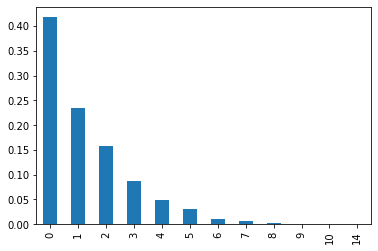

In [25]:
from empiricaldist import Pmf

pmf_prior_pred = Pmf.from_seq(sample_prior_pred)
pmf_prior_pred.plot(kind="bar")

We have two reasons for doing this. First of all, we should check to see that this makes sense. Looking at it, it roughly conforms with our idea of how many goals are scored in soccer matches. Second, this is the first step toward using MCMC!

## Introducing PyMC3

PyMC3 is a library that provides several MCMC methods. To use PyMC3, we need to specify a model of the process that generate the data. In this example, the model has two steps:
1. First we draw a goal-scoring rate from the prior distribution
2. The we draw a number of goals from a Poisson distribution

Here's how we specify this model in PyMC3:

In [26]:
import pymc3 as pm

with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam)

The first line creates the prior, which is a gamma distribution with the given parameters

The second line creates the prior predictive, which is a Poisson distribution with the parameter `lam`

(The first parameter for `Gamma` and `Poisson` is a string variable name

## Sampling the Prior

PyMC3 provides a function that generates samples from the prior and prior predictive distributions. We can use a `with` statement to rin this function in the context of the model

In [27]:
with model:
    trace = pm.sample_prior_predictive(1000)

The result is a dictionary-like object that maps from the variables, `lam` and `goals`, to the samples. We can extract the sample of `lam` like this:

In [28]:
sample_prior_pymc = trace['lam']
sample_prior_pymc.shape

(1000,)

If we compare the results to what we did earlier, we see that they are very similar.

We can also extract the goals:

In [30]:
sample_prior_pred_pymc = trace['goals']
sample_prior_pred_pymc

array([ 2,  1,  1,  2,  2,  1,  1,  0,  3,  0,  2,  0,  1,  0,  0,  1,  1,
        1,  1,  1,  3,  0,  3,  0,  0,  0,  0,  0,  0,  1,  0,  0,  3,  3,
        2,  2,  3,  2,  2,  1,  0,  0,  1,  1,  0,  1,  0,  1,  3,  0,  3,
        0,  5,  0,  1,  0,  1,  1,  0,  0,  2,  1,  1,  0,  1,  0,  0,  2,
        0,  1,  3,  0,  0,  4,  0,  1,  5,  1,  1,  0,  1,  1,  1,  4,  0,
        0,  1,  7,  1,  1,  5,  0,  0,  2,  2,  4,  1,  3,  1,  6,  1,  4,
        3,  0,  0,  3,  0,  2,  0,  6,  2,  3,  1,  3,  0,  1,  1,  0,  1,
        2,  1,  2,  3,  4,  4,  5,  0,  0,  2,  2,  0,  0,  1,  0,  0,  6,
        0,  1,  2,  1,  1,  1,  1,  4,  0,  1,  2,  1,  0,  6,  1,  2,  0,
        0,  8,  4,  0,  2,  1,  1,  0,  1,  0,  0,  2,  0,  0,  6,  0,  0,
        0,  2,  1,  1,  0,  1,  3,  1,  4,  0,  3,  1,  1,  0,  0,  3,  0,
        3,  3,  1,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  2,
        0,  4,  0,  3,  0,  1,  0,  0,  2,  0,  0,  1,  0,  2,  0,  1,  1,
        2,  0,  5,  0,  2

<AxesSubplot:>

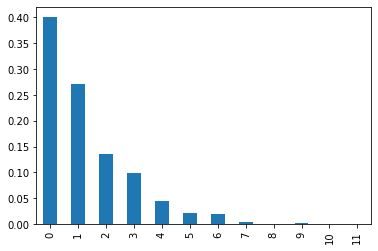

In [31]:
pymc_goals_pmf = Pmf.from_seq(sample_prior_pred_pymc)
pymc_goals_pmf.plot(kind="bar")

Again, the results are similar, so we are fairly confident that we are using PyMC3 correctly.

## When Do We Get To Inference?

Let's do some actual inference! We just have to make one small change:

Here's what we used for the prior predictive distribution:
```python
with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam)
```

In [32]:
# Posterior predictive
with pm.Model() as model2:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam, observed=4)
    
# The difference is that we are marking goals as observed and setting the value as 4
# now instead of calling `sample_prior_predictive`, we'll call `sample`, which is understood to sample from the posterior distribution of `lam`:

options = dict(return_inferencedata=False)

with model2:
    trace2 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


The sampling process is obviously very different!

1. Depending on the model, PyMC3 uses several different samplers: in this case, the No U-Turn Sampler (NUTS), which is very efficient and robust
1. When the sampler starts, the first values are generally not a distributive sample of the posterior, and so are discarded - this is called 'tuning'
1. Instead of using a single Markov chain, multiple are used. Then we can compare results from different chains to make sure they are consistent.

Although we asked for a sample of 500, PyMC3 generated two samples of 1000 and discarded half of each, and returned the remaining 1000. From trace2 we can extract a sample from the posterior distribution like this:

<AxesSubplot:>

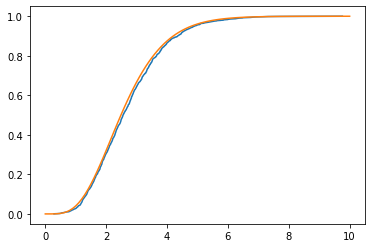

In [33]:
sample_post_pymc = trace2['lam']
posterior_pymc_lam = Pmf.from_seq(sample_post_pymc).make_cdf()
posterior_pymc_lam.plot()

# also plot the one we made without PyMC3
posterior.make_cdf().plot()

So we can see that we have good consistency!

## Posterior Predictive Distribution

The previous results were for $\lambda$; we can also generate the posterior predictive (for the goals):

<AxesSubplot:>

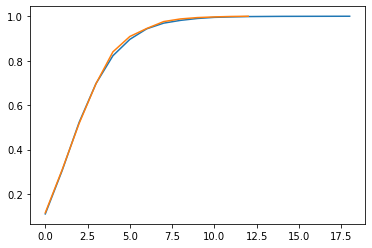

In [34]:
with model2:
    post_pred = pm.sample_posterior_predictive(trace2)
    
sample_post_pred_pymc = post_pred['goals']

# also a sample from the posterior distribution we found using grid methods
sample_post = posterior.sample(1000)
sample_post_pred = poisson(sample_post).rvs()

Pmf.from_seq(sample_post_pred_pymc).make_cdf().plot()
Pmf.from_seq(sample_post_pred).make_cdf().plot()

Again, we have good agreement between the methods.

However, so far PyMC3 computes the same result, except it is slower and more complex than just using a grid method. So why use it?

Hopefully it will become clear with a more complex model:

## Happiness

- Book or Article? `Happines and Life Satisfaction`.

Discusses the relationship between happiness and a bunch of other variables

- Income as represented by per capita GDP
- Social support
- Healthy life expectancy at birth
- Freedom to make life choices
- Generosity
- Perceptions of corruption

The dependent variables is the national average of responses to the "Cantril ladder question" used by the Gallup World Poll.

> Please imagine a ladder with steps numbered from zero at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the lader represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?

In the next few sections we'll replicate the analysis in this report using Bayesian regression.

In [40]:
df = pd.read_excel("data/WHR20_DataForFigure2.1.xls")
df.head()

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900826,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266


In [42]:
score = df['Ladder score']

## Simple Regression

Let's look at the relationship between happiness and income as represented by GDP per person.

The column named 'Logged GDP per capita' represents the natural log of the GDP of the country divided by the number of people therein, corrected for the purchasing power parity (PPP). 

Text(0, 0.5, 'Happiness ladder score')

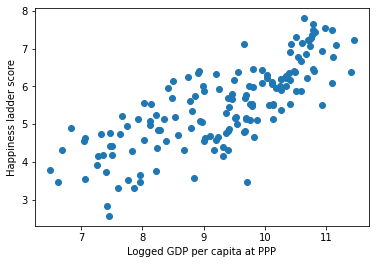

In [45]:
log_gdp = df['Logged GDP per capita']

# now let's take a look at the plot
fig, ax = plt.subplots()
ax.scatter(log_gdp, score)
ax.set_xlabel("Logged GDP per capita at PPP")
ax.set_ylabel("Happiness ladder score")

In [46]:
# It's clear that there is a relationship between these variables; let's make it more specific
from scipy.stats import linregress
result = linregress(log_gdp, score)
result

LinregressResult(slope=0.717738495630452, intercept=-1.1986460618088843, rvalue=0.7753744007429199, pvalue=5.983050807797873e-32, stderr=0.047570849726545426, intercept_stderr=0.44585973641760784)

In [48]:
result.slope, result.intercept

(0.717738495630452, -1.1986460618088843)

In [50]:
# Do some Bayesian regression using the model of y = ax + b + epsilon
# epsilon is a random variable ~Normal(0, sigma)

x_data = log_gdp
y_data = score
with pm.Model() as model3:
    a = pm.Uniform('a', 0, 4)
    b = pm.Uniform('b', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)
    
    y_est = a * x_data + b
    y = pm.Normal('y', mu=y_est, sd=sigma, observed=y_data)

The prior distributions for `a`, `b`, and `sigma` are uniform with ranges wide enough to cover the posterior distribution.

`y_est` is the estimated value of the dependent variable based on the regression equation. `y` is a normal distribution with mean `y_est` and standard deviation `sigma`.

Notice how the data are included in the model:
- The values of teh predictive variable, `x_data`, are used to compute `y_est`.
- The values of the dependent variable, `y_data`, are provied as the observed values of `y`.

Now we can use the model to generate a sample from the posterior distribution:

In [51]:
with model3:
    trace3 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.9124468074661536, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


The result is an object that contains samples from the joint posterior distribution of `a`, `b`, and `sigma`.

In [53]:
dir(trace3)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_attrs',
 '_report',
 '_slice',
 '_straces',
 'add_values',
 'chains',
 'get_sampler_stats',
 'get_values',
 'nchains',
 'point',
 'points',
 'remove_values',
 'report',
 'stat_names',
 'varnames']

In [57]:
trace3.varnames

['a_interval__', 'b_interval__', 'sigma_interval__', 'a', 'b', 'sigma']

In [58]:
trace3['a']

array([0.69702234, 0.75088787, 0.74170009, ..., 0.72837499, 0.73659509,
       0.74271073])

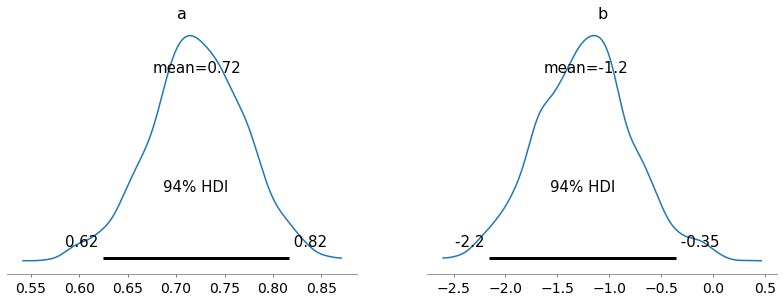

In [59]:
# ArviZ provides plot_posterior, which we can use to plot the posterior distributions.
import arviz as az

with model3:
    az.plot_posterior(trace3, var_names=['a', 'b'])

The graphs show the distributions of the samples, estimated by KDE, and 94% credible intervals. In the figures, HDI stands for "highest-density intervals". The means of these samples are consistent with the parameters we estimated with `linregress`.

The simple regression model has only three parameters, so we could have used a grid method. But the regression model in the happiness report has six predictive variables, so it has eight parameters in total, including `intercept` and `sigma`.

It is simply not practical to compute a grid approximation for a model with eight parameters. Even a coarse grid, with 20 points along each dimension, would have more than 25 billion points. And with 153 countries we would have to compute almost 4 trillion likelihoods.

But PyMC3 can handle a model with eight parameters comfortably, as we'll see.

## Multiple Regression

Before we implement the multiple regression model, let's select the columns that we need:

In [60]:
columns = [
    'Ladder score',
    'Logged GDP per capita',
    'Social support',
    'Healthy life expectancy',
    'Freedom to make life choices',
    'Generosity',
    'Perceptions of corruption'
]

subset = df[columns]

In [61]:
# The predictive variables all have different units, so let's first normalize (z score)
standardized = (subset - subset.mean()) / subset.std()

In [62]:
# Now let's build the model. First we extract the variables:
y_data = standardized['Ladder score']

x1 = standardized[columns[1]]
x2 = standardized[columns[2]]
x3 = standardized[columns[3]]
x4 = standardized[columns[4]]
x5 = standardized[columns[5]]
x6 = standardized[columns[6]]

# Here's the model. `b0` is the intercept - b1-b6 are the parameters associated with the predictive variables
with pm.Model() as model4:
    b0 = pm.Uniform('b0', -4, 4)
    b1 = pm.Uniform('b1', -4, 4)
    b2 = pm.Uniform('b2', -4, 4)
    b3 = pm.Uniform('b3', -4, 4)
    b4 = pm.Uniform('b4', -4, 4)
    b5 = pm.Uniform('b5', -4, 4)
    b6 = pm.Uniform('b6', -4, 4)
    sigma = pm.Uniform('sigma', 0, 2)
    
    y_est = b0 + b1*x1 + b2*x2 + b3*x3 + b4*x4 + b5*x5 + b6*x6
    y = pm.Normal('y', mu=y_est, sd=sigma, observed=y_data)

In [63]:
# now sample from the joist posterior distributions:
with model4:
    trace4 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b6, b5, b4, b3, b2, b1, b0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 3 seconds.


In [65]:
param_names = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6']
means = [trace4[name].mean() for name in param_names]

In [67]:
# We can also compute 94% credible intervals:
def credible_interval(sample):
    ci = np.percentile(sample, [3, 97])
    return np.round(ci, 3)

cis = [credible_interval(trace4[name]) for name in param_names]
cis

[array([0.093, 0.411]),
 array([0.161, 0.428]),
 array([0.068, 0.358]),
 array([0.086, 0.291]),
 array([-0.033,  0.146]),
 array([-0.194, -0.007])]

In [72]:
# Summary
summary = pd.DataFrame(index=columns[1:])
summary["94% CI"] = cis
summary["Posterior Mean"] = means
summary

,94% CI,Posterior Mean
Logged GDP per capita,"[0.093, 0.411]",0.253683
Social support,"[0.161, 0.428]",0.296475
Healthy life expectancy,"[0.068, 0.358]",0.218833
Freedom to make life choices,"[0.086, 0.291]",0.187011
Generosity,"[-0.033, 0.146]",0.057233
Perceptions of corruption,"[-0.194, -0.007]",-0.100583


While this is cool, Bayesian regression doesn't really offer too much extra over regular least-squares regression. The real advantages come in if / when you use these as part of a decision process.

## Summary
MCMC is more powerful than grid methods, but comes with some disadvantages:
- The algorithms are fiddly. The process can converge with some priors but not others, and it can take quite a bit of expertise to diagnose the issues.
- It is much easier to develop models incrementally using grid models.

## Exercises

### Exercise 19-1

As a warm up, let's use PyMC3 to solve the Euro problem. Suppose we flip a coin 250 times, and it comes up heads 140 times. What is the posterior distribution of $x$, the probability of heads?

For the prior, use a beta distribution with parameters $\alpha=1$ and $\beta=1$. 

See the PyMC3 documentation for the list of continuous distributions

### Exercise 19-1 Solution

In [77]:
[True] * 2 + [False] * 3

[True, True, False, False, False]

In [78]:
# We have a prior of alpha=1, beta=1
# our data is 140 times of 250
with pm.Model() as euro_model:
    x = pm.Beta('x', alpha=1, beta=1)
    p = pm.Binomial('p', n=250, p=x, observed=140)

In [79]:
with euro_model:
    euro_trace = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


In [84]:
euro_trace.varnames

['x_logodds__', 'x']

In [91]:
xs = euro_trace['x']
xs

array([0.55637936, 0.55072742, 0.54738196, ..., 0.58035375, 0.58035375,
       0.54780969])

<AxesSubplot:title={'center':'x'}>

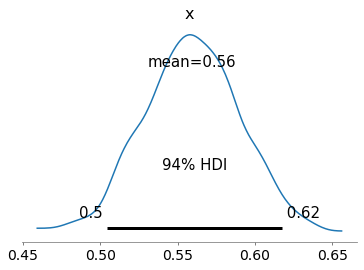

In [92]:
az.plot_posterior(xs)

### Exercise 19-2

Now let's use PyMC3 to replicate the solution the solution to the Grizzly Bear problem, which was based on the hypergeometric distribution.

Here's the problem, presented with slightly different variables to make it consistent with PyMC3.

Suppose that during the first session, `k=23` bears are tagged. During the second session, `n=19` are identified, of which `x=4` have been tagged.

Estimate the distribution of `N`, the number of bears in the environment.

For the prior, use the discrete uniform distribution from 50 -- 500.

See the PyMC3 documentation for the list of discrete distributions.

Note: the `HyperGeometric` distribution was added in version 3.8, so you might need to update.

### Exercise 19-2 Solution

In [103]:
# First, we have the number of bears, N - the prior will be discrete uniform from 50 - 500
# K is the number of bears observed in the first session: 23 - these are the "Success" type bears
# n is the number of "draws" - bears observed in the second session: 19 - this is the "number of draws"
# from that, x = 4 have already been observed - this is what actually happened

with pm.Model() as bear_model:
    N = pm.DiscreteUniform('N', lower=50, upper=500)
    x = pm.HyperGeometric('x', N=N, k=23, n=19, observed=4)

In [107]:
with bear_model:
    bear_sample = pm.sample(10000, **options)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [N]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [105]:
bear_sample.varnames

['N']

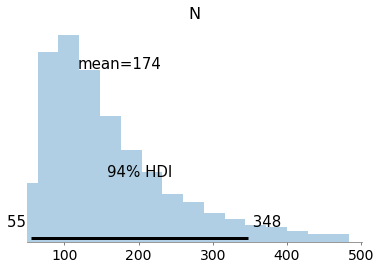

In [108]:
with bear_model:
    az.plot_posterior(bear_sample)

### Exercise 19-3

In "The Weibull Distribution", we generated a sample from a Weibull distribution with $\lambda=3$ and $k=0.8$. Then we used the data to compute a grid approximation of the posterior distribution of the parameters.

Let's do the same with PyMC3.

For the priors, you can use uniform distributions as we did in Chapter 14, or you could use `HalfNormal` distributions provided by PyMC3.

Note: The `Weibull` class in PyMC3 uses different parameters thant SCiPy. The parameter `alpha` in PyMC3 corresponds to `k`, and `beta` corresponds to $\lambda$.

`data = [0.80497283, 2.11577082, 0.43308797, 0.10862644, 5.17334866,
       3.25745053, 3.05555883, 2.47401062, 0.05340806, 1.08386395]`

### Exercise 19-3 Solution

In [110]:
# We start with uniform priors for lambda and k
with pm.Model() as weibull_model:
    lam = pm.Uniform('lam', lower=0.1, upper=10.1)
    k = pm.Uniform('k', 0.1, 5.1)
    lifetime = pm.Weibull('lifetime', alpha=k, beta=lam, observed=data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, lam]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 8 seconds.
There were 346 divergences after tuning. Increase `target_accept` or reparameterize.
There were 243 divergences after tuning. Increase `target_accept` or reparameterize.
There were 850 divergences after tuning. Increase `target_accept` or reparameterize.
There were 943 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


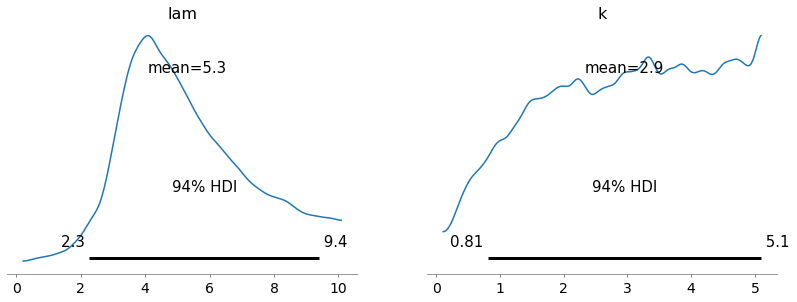

In [115]:
with weibull_model:
    weibull_sample = pm.sample(10000, **options)
    az.plot_posterior(weibull_sample)

### Exercise 19-4

In "Improving Reading Ability", we used data from a reading test to estimate the parameters of a normal distribution. Make a model that defines uniform prior distributions for `mu` and `sigma` and uses the data to estimate their posterior distributions.

### Exercise 19-4 Solution

In [117]:
# get the data
df = pd.read_csv("data/drp_scores.csv", skiprows=21, delimiter="\t")
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


In [119]:
grouped = df.groupby("Treatment")

responses = {name: group['Response'] for name, group in grouped}
responses

{'Control': 21    42
 22    43
 23    55
 24    26
 25    62
 26    37
 27    33
 28    41
 29    19
 30    54
 31    20
 32    85
 33    46
 34    10
 35    17
 36    60
 37    53
 38    42
 39    37
 40    42
 41    55
 42    28
 43    48
 Name: Response, dtype: int64,
 'Treated': 0     24
 1     43
 2     58
 3     71
 4     43
 5     49
 6     61
 7     44
 8     67
 9     49
 10    53
 11    56
 12    59
 13    52
 14    62
 15    54
 16    57
 17    33
 18    46
 19    43
 20    57
 Name: Response, dtype: int64}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [treated_sigma, treated_mu, control_sigma, control_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.6368452912236953, but should be close to 0.8. Try to increase the number of tuning steps.


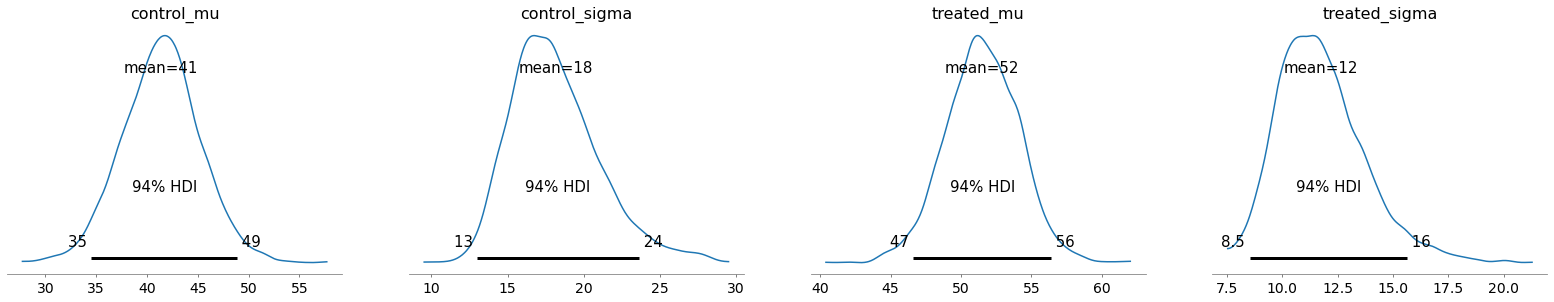

In [123]:
with pm.Model() as reading_model:
    control_mu = pm.Uniform('control_mu', lower=20, upper=80)
    control_sigma = pm.Uniform('control_sigma', lower=5, upper=30)
    control_response = pm.Normal('control_response', mu=control_mu, sigma=control_sigma, observed=responses['Control'])
    
    treated_mu = pm.Uniform('treated_mu', lower=20, upper=80)
    treated_sigma = pm.Uniform('treated_sigma', lower=5, upper=30)
    treated_response = pm.Normal('treated_response', mu=treated_mu, sigma=treated_sigma, observed=responses['Treated'])
    
    sample = pm.sample(1000, **options)
    az.plot_posterior(sample)

### Exercise 19-5

In "The Lincoln Index Problem" we used a grid algorithm to solve the Lincoln Index Problem as presented by John D. Cook:

> [...]

(Bug testing)

Suppose the first tester finds 20 bugs and the second tester find 15, of which there are 3 in common. Use PyMC3 to estimate the number of bugs.

Note: This exercise is more difficult than some of the previous ones. One of the challenges is that the data includes `k00`, which is dependent on `N`:

`k00 = N - num_seen`.

So we have to construct the data as part of the model. To do that, we can use `pm.math.stack`, which makes an array:

`data = pm.math.stack((k00, k01, k10, k11))`

Finally, you might find it helpful to use `pm.Multinomial`.

In [137]:
# Basic idea: assign a probability of finding a bug to each of the testers. Then for each categoty:
# k11 - both find them = p0 * p1
# k10 - first one finds it, second doesn't = p0 * (1 - p1)
# k01 - first one misses it, second one finds it = (1 - p0) * p1
# k00 - both miss it = (1 - p0) * (1 - p1)
# Then we can model this as a multinomial distribution where each of those is the probability of one of the categories appearing
# We know the values for the first three, and then if N is the total number of bugs, k00 = N - k01 - k10 - k11

k11 = 3
k10 = 20 - k11
k01 = 15 - k11
total_observed = 20 + 15 - 3
with pm.Model() as bug_model:
    N = pm.DiscreteUniform('N', 32, 350)
    p0 = pm.Uniform('p0', 0, 1)
    p1 = pm.Uniform('p1', 0, 1)
    y = pm.Multinomial('y', n=N, p=[p0 * p1, p0 * (1 - p1), (1-p0) * p1, (1-p0) * (1-p1)], observed=pm.math.stack(k11, k10, k01, N - total_observed))

In [142]:
with bug_model:
    bug_sample = pm.sample(500, **options)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [N]
>NUTS: [p1, p0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.5979197868517859, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


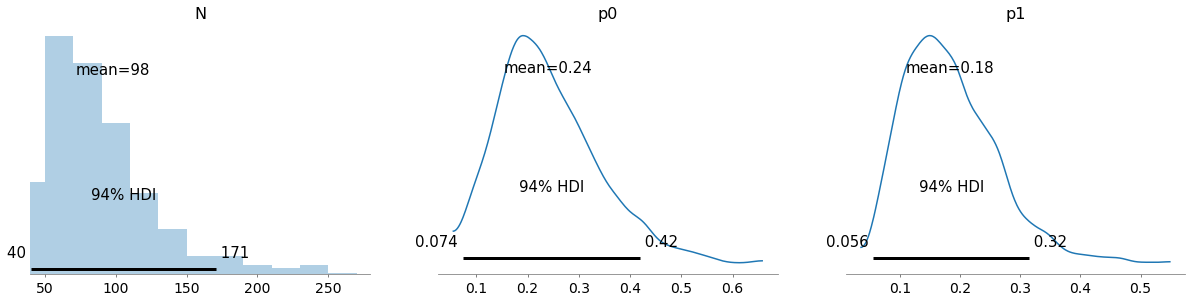

In [143]:
with bug_model:
    az.plot_posterior(bug_sample)